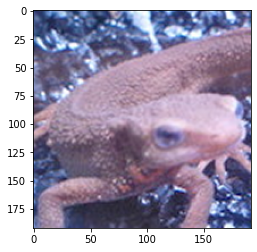

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Bi-cubic interpolation
def bc_interpolate(img, ax=1., ay=1.):
	H, W, C = img.shape

	aH = int(ay * H)
	aW = int(ax * W)

	# get positions of resized image
	y = np.arange(aH).repeat(aW).reshape(aH, -1)
	x = np.tile(np.arange(aW), (aH, 1))
	y = (y / ay)
	x = (x / ax)

	# get positions of original image
	ix = np.floor(x).astype(np.int)
	iy = np.floor(y).astype(np.int)

	ix = np.minimum(ix, W-1)
	iy = np.minimum(iy, H-1)

	# get distance of each position of original image
	dx2 = x - ix
	dy2 = y - iy
	dx1 = dx2 + 1
	dy1 = dy2 + 1
	dx3 = 1 - dx2
	dy3 = 1 - dy2
	dx4 = 1 + dx3
	dy4 = 1 + dy3

	dxs = [dx1, dx2, dx3, dx4]
	dys = [dy1, dy2, dy3, dy4]

	# bi-cubic weight
	def weight(t):
		a = -1.
		at = np.abs(t)
		w = np.zeros_like(t)
		ind = np.where(at <= 1)
		w[ind] = ((a+2) * np.power(at, 3) - (a+3) * np.power(at, 2) + 1)[ind]
		ind = np.where((at > 1) & (at <= 2))
		w[ind] = (a*np.power(at, 3) - 5*a*np.power(at, 2) + 8*a*at - 4*a)[ind]
		return w

	w_sum = np.zeros((aH, aW, C), dtype=np.float32)
	out = np.zeros((aH, aW, C), dtype=np.float32)

	# interpolate
	for j in range(-1, 3):
		for i in range(-1, 3):
			ind_x = np.minimum(np.maximum(ix + i, 0), W-1)
			ind_y = np.minimum(np.maximum(iy + j, 0), H-1)

			wx = weight(dxs[i+1])
			wy = weight(dys[j+1])
			wx = np.repeat(np.expand_dims(wx, axis=-1), 3, axis=-1)
			wy = np.repeat(np.expand_dims(wy, axis=-1), 3, axis=-1)

			w_sum += wx * wy
			out += wx * wy * img[ind_y, ind_x]

	out /= w_sum
	out = np.clip(out, 0, 255)
	out = out.astype(np.uint8)

	return out


# Read image
img = cv2.imread("../imori.jpg").astype(np.float32)

# Bi-cubic interpolation
out = bc_interpolate(img, ax=1.5, ay=1.5)

# Save result
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))